Understanding GAN's: https://medium.com/datadriveninvestor/deep-learning-generative-adversarial-network-gan-34abb43c0644

![](https://miro.medium.com/max/2176/1*t78gwhhw-hn1CgXc1K89wA.png)

Das Ziel des Generators ist es, Daten zu generieren, die den Trainingsdaten sehr ähnlich sind. 

Vom Generator generierte Daten sollten nicht von den tatsächlichen Daten zu unterscheiden sein.


Diskriminator verwendet zwei Sätze von Eingaben, 
- eine Eingabe stammt aus dem Trainingsdatensatz (Realdaten) 
- und die andere Eingabe ist der vom Generator generierte Datensatz.

GAN verwendet die MNIST-Daten und identifiziert die latente Merkmalsdarstellung zum Erzeugen von Ziffern. 

Am Ende werden wir sehen, wie die Generatoren echt aussehende MNIST-Ziffern erzeugen können.

## Importieren wir die benötigten Bibliotheken

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

Using TensorFlow backend.


## Laden der Daten aus dem Mnist-Datensatz. 
Wir erstellen eine Funktion load_data () Funktion

In [3]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # konvertieren der Shape von x_train von (60000, 28, 28) zu (60000, 784) 
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

(60000, 784)


## Adam Optimizer
Wir werden den Adam-Optimierer verwenden, da dieser recheneffizient ist und nur sehr wenig Speicher benötigt. 

Adam ist eine Kombination aus Adagrad und RMSprop.

In [4]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

## Visualisierung der GAN-Architektur

![](https://miro.medium.com/max/1134/1*Sqhji7Zz4IK2HDgCOabhXQ.png)

## Erstellen des Generators
Wir erstellen einen Generator, aus Dense-Layern die durch `tanh` aktiviert werden

In [5]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
g=create_generator()
g.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
___________________________________________

## Erstellen des Diskriminators
Wir erstellen jetzt den Diskriminator aus Dense-Layern.

Der Diskriminator nimmt die Eingabe von den _realen_ Daten der Größe 784 und auch die vom Generator erzeugten Bilder auf.

In [6]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________________________

## Erstellen des GAN
Wir erstellen jetzt das GAN, in der wir den Generator und den Diskriminator kombinieren. 

Wenn wir den Generator trainieren, werden wir den Diskriminator einfrieren.

Wir geben das verrauschte Bild mit einer Form von 100 Einheiten in den Generator ein. 

Das vom Generator erzeugte Ausgangssignal wird dem Diskriminator zugeführt.

In [7]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


## generierte Bilder zeichnen & speichern
Bevor wir mit dem Training des Modells beginnen, schreiben wir eine Funktion `plot_generated_images`, um die generierten Bilder zu zeichnen. 

Auf diese Weise können wir sehen, wie die Bilder erzeugt werden. 

Wir speichern die generierten Bilder in einer Datei, die wir später anzeigen können

In [8]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

## disable scrollable frames

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## GAN trainieren

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1










  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 4


  1%|          | 1/128 [00:00<00:23,  5.49it/s]

Epoch 5


  2%|▏         | 2/128 [00:00<00:12, 10.22it/s]

Epoch 6


  1%|          | 1/128 [00:00<00:15,  8.26it/s]

Epoch 7


  2%|▏         | 2/128 [00:00<00:11, 10.71it/s]

Epoch 8


  1%|          | 1/128 [00:00<00:13,  9.60it/s]

Epoch 9


  2%|▏         | 2/128 [00:00<00:11, 10.87it/s]

Epoch 10


  1%|          | 1/128 [00:00<00:14,  8.85it/s]

Epoch 11


  1%|          | 1/128 [00:00<00:13,  9.23it/s]

Epoch 12


  2%|▏         | 2/128 [00:00<00:11, 11.00it/s]

Epoch 13


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 14


  2%|▏         | 2/128 [00:00<00:11, 10.66it/s]

Epoch 15


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 16


  2%|▏         | 2/128 [00:00<00:11, 10.83it/s]

Epoch 17


  1%|          | 1/128 [00:00<00:12,  9.91it/s]

Epoch 18


  2%|▏         | 2/128 [00:00<00:12, 10.43it/s]

Epoch 19


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 20


  2%|▏         | 2/128 [00:00<00:12, 10.36it/s]

Epoch 21


  1%|          | 1/128 [00:00<00:16,  7.89it/s]

Epoch 22


  2%|▏         | 2/128 [00:00<00:11, 10.60it/s]

Epoch 23


  1%|          | 1/128 [00:00<00:12,  9.99it/s]

Epoch 24


  2%|▏         | 2/128 [00:00<00:11, 10.88it/s]

Epoch 25


  2%|▏         | 2/128 [00:00<00:11, 10.89it/s]

Epoch 26


  1%|          | 1/128 [00:00<00:12,  9.91it/s]

Epoch 27


  2%|▏         | 2/128 [00:00<00:11, 10.62it/s]

Epoch 28


  2%|▏         | 2/128 [00:00<00:11, 10.63it/s]

Epoch 29


  2%|▏         | 2/128 [00:00<00:11, 11.27it/s]

Epoch 30


  1%|          | 1/128 [00:00<00:17,  7.25it/s]

Epoch 31


  2%|▏         | 2/128 [00:00<00:11, 11.00it/s]

Epoch 32


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 33


  2%|▏         | 2/128 [00:00<00:12, 10.47it/s]

Epoch 34


  1%|          | 1/128 [00:00<00:13,  9.48it/s]

Epoch 35


  2%|▏         | 2/128 [00:00<00:11, 10.85it/s]

Epoch 36


  1%|          | 1/128 [00:00<00:13,  9.59it/s]

Epoch 37


  2%|▏         | 2/128 [00:00<00:11, 11.14it/s]

Epoch 38


  2%|▏         | 2/128 [00:00<00:11, 11.21it/s]

Epoch 39


  1%|          | 1/128 [00:00<00:12,  9.88it/s]

Epoch 40


  1%|          | 1/128 [00:00<00:13,  9.61it/s]

Epoch 41


  1%|          | 1/128 [00:00<00:15,  8.29it/s]

Epoch 42


  1%|          | 1/128 [00:00<00:13,  9.76it/s]

Epoch 43


  2%|▏         | 2/128 [00:00<00:10, 11.64it/s]

Epoch 44


  2%|▏         | 2/128 [00:00<00:11, 11.13it/s]

Epoch 45


  2%|▏         | 2/128 [00:00<00:11, 10.76it/s]

Epoch 46


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 47


  2%|▏         | 2/128 [00:00<00:12, 10.18it/s]

Epoch 48


  1%|          | 1/128 [00:00<00:18,  6.95it/s]

Epoch 49


  2%|▏         | 2/128 [00:00<00:11, 11.00it/s]

Epoch 50


  2%|▏         | 2/128 [00:00<00:11, 10.72it/s]

Epoch 51


  2%|▏         | 2/128 [00:00<00:11, 11.12it/s]

Epoch 52


  2%|▏         | 2/128 [00:00<00:11, 10.58it/s]

Epoch 53


  1%|          | 1/128 [00:00<00:14,  8.51it/s]

Epoch 54


  2%|▏         | 2/128 [00:00<00:11, 11.12it/s]

Epoch 55


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 56


  1%|          | 1/128 [00:00<00:14,  8.52it/s]

Epoch 57


  2%|▏         | 2/128 [00:00<00:12, 10.19it/s]

Epoch 58


  2%|▏         | 2/128 [00:00<00:11, 10.91it/s]

Epoch 59


  2%|▏         | 2/128 [00:00<00:11, 11.13it/s]

Epoch 60


  2%|▏         | 2/128 [00:00<00:11, 10.66it/s]

Epoch 61


  2%|▏         | 2/128 [00:00<00:11, 11.07it/s]

Epoch 62


  1%|          | 1/128 [00:00<00:13,  9.73it/s]

Epoch 63


  2%|▏         | 2/128 [00:00<00:11, 10.80it/s]

Epoch 64


  2%|▏         | 2/128 [00:00<00:11, 10.88it/s]

Epoch 65


  2%|▏         | 2/128 [00:00<00:11, 11.07it/s]

Epoch 66


  2%|▏         | 2/128 [00:00<00:11, 10.65it/s]

Epoch 67


  2%|▏         | 2/128 [00:00<00:11, 10.64it/s]

Epoch 68


  1%|          | 1/128 [00:00<00:18,  7.03it/s]

Epoch 69


  2%|▏         | 2/128 [00:00<00:11, 10.98it/s]

Epoch 70


  2%|▏         | 2/128 [00:00<00:11, 10.58it/s]

Epoch 71


  1%|          | 1/128 [00:00<00:13,  9.10it/s]

Epoch 72


  2%|▏         | 2/128 [00:00<00:11, 10.69it/s]

Epoch 73


  1%|          | 1/128 [00:00<00:13,  9.13it/s]

Epoch 74


  2%|▏         | 2/128 [00:00<00:11, 10.64it/s]

Epoch 75


  2%|▏         | 2/128 [00:00<00:11, 10.86it/s]

Epoch 76


  2%|▏         | 2/128 [00:00<00:11, 10.87it/s]

Epoch 77


  1%|          | 1/128 [00:00<00:13,  9.68it/s]

Epoch 78


  1%|          | 1/128 [00:00<00:12,  9.91it/s]

Epoch 79


  1%|          | 1/128 [00:00<00:17,  7.41it/s]

Epoch 80


  2%|▏         | 2/128 [00:00<00:11, 10.79it/s]

Epoch 81


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 82


  2%|▏         | 2/128 [00:00<00:11, 10.69it/s]

Epoch 83


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 84


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 85


  1%|          | 1/128 [00:00<00:18,  6.94it/s]

Epoch 86


  2%|▏         | 2/128 [00:00<00:11, 10.63it/s]

Epoch 87


  2%|▏         | 2/128 [00:00<00:11, 11.19it/s]

Epoch 88


  2%|▏         | 2/128 [00:00<00:11, 11.00it/s]

Epoch 89


  2%|▏         | 2/128 [00:00<00:11, 11.10it/s]

Epoch 90


  2%|▏         | 2/128 [00:00<00:11, 11.16it/s]

Epoch 91


  2%|▏         | 2/128 [00:00<00:11, 11.05it/s]

Epoch 92


  2%|▏         | 2/128 [00:00<00:11, 10.72it/s]

Epoch 93


  2%|▏         | 2/128 [00:00<00:12, 10.41it/s]

Epoch 94


  1%|          | 1/128 [00:00<00:13,  9.32it/s]

Epoch 95


  2%|▏         | 2/128 [00:00<00:11, 10.84it/s]

Epoch 96


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 97


  1%|          | 1/128 [00:00<00:15,  8.22it/s]

Epoch 98


  2%|▏         | 2/128 [00:00<00:11, 10.63it/s]

Epoch 99


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 100


  2%|▏         | 2/128 [00:00<00:11, 10.73it/s]

Epoch 101


  1%|          | 1/128 [00:00<00:13,  9.30it/s]

Epoch 102


  1%|          | 1/128 [00:00<00:14,  8.77it/s]

Epoch 103


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 104


  1%|          | 1/128 [00:00<00:13,  9.48it/s]

Epoch 105


  2%|▏         | 2/128 [00:00<00:11, 10.69it/s]

Epoch 106


  1%|          | 1/128 [00:00<00:19,  6.61it/s]

Epoch 107


  1%|          | 1/128 [00:00<00:12,  9.89it/s]

Epoch 108


  2%|▏         | 2/128 [00:00<00:11, 10.53it/s]

Epoch 109


  1%|          | 1/128 [00:00<00:12,  9.95it/s]

Epoch 110


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 111


  1%|          | 1/128 [00:00<00:12,  9.81it/s]

Epoch 112


  1%|          | 1/128 [00:00<00:15,  8.33it/s]

Epoch 113


  1%|          | 1/128 [00:00<00:13,  9.32it/s]

Epoch 114


  1%|          | 1/128 [00:00<00:13,  9.59it/s]

Epoch 115


  1%|          | 1/128 [00:00<00:20,  6.25it/s]

Epoch 116


  2%|▏         | 2/128 [00:00<00:12, 10.16it/s]

Epoch 117


  1%|          | 1/128 [00:00<00:13,  9.14it/s]

Epoch 118


  1%|          | 1/128 [00:00<00:13,  9.57it/s]

Epoch 119


  1%|          | 1/128 [00:00<00:13,  9.32it/s]

Epoch 120


  1%|          | 1/128 [00:00<00:12,  9.95it/s]

Epoch 121


  2%|▏         | 2/128 [00:00<00:12, 10.23it/s]

Epoch 122


  2%|▏         | 2/128 [00:00<00:12, 10.36it/s]

Epoch 123


  1%|          | 1/128 [00:00<00:13,  9.31it/s]

Epoch 124


  1%|          | 1/128 [00:00<00:13,  9.30it/s]

Epoch 125


  1%|          | 1/128 [00:00<00:12,  9.78it/s]

Epoch 126


  2%|▏         | 2/128 [00:00<00:12, 10.29it/s]

Epoch 127


  2%|▏         | 2/128 [00:00<00:11, 10.64it/s]

Epoch 128


  2%|▏         | 2/128 [00:00<00:12, 10.26it/s]

Epoch 129


  1%|          | 1/128 [00:00<00:12,  9.80it/s]

Epoch 130


  2%|▏         | 2/128 [00:00<00:11, 10.63it/s]

Epoch 131


  2%|▏         | 2/128 [00:00<00:12, 10.31it/s]

Epoch 132


  2%|▏         | 2/128 [00:00<00:11, 10.63it/s]

Epoch 133


  2%|▏         | 2/128 [00:00<00:11, 10.55it/s]

Epoch 134


  2%|▏         | 2/128 [00:00<00:12, 10.22it/s]

Epoch 135


  2%|▏         | 2/128 [00:00<00:11, 10.76it/s]

Epoch 136


  1%|          | 1/128 [00:00<00:13,  9.27it/s]

Epoch 137


  1%|          | 1/128 [00:00<00:13,  9.21it/s]

Epoch 138


  1%|          | 1/128 [00:00<00:19,  6.54it/s]

Epoch 139


  1%|          | 1/128 [00:00<00:13,  9.34it/s]

Epoch 140


  1%|          | 1/128 [00:00<00:12,  9.78it/s]

Epoch 141


  1%|          | 1/128 [00:00<00:12,  9.81it/s]

Epoch 142


  2%|▏         | 2/128 [00:00<00:11, 10.56it/s]

Epoch 143


  2%|▏         | 2/128 [00:00<00:12, 10.25it/s]

Epoch 144


  1%|          | 1/128 [00:00<00:13,  9.26it/s]

Epoch 145


  2%|▏         | 2/128 [00:00<00:12, 10.43it/s]

Epoch 146


  1%|          | 1/128 [00:00<00:13,  9.29it/s]

Epoch 147


  1%|          | 1/128 [00:00<00:13,  9.28it/s]

Epoch 148


  2%|▏         | 2/128 [00:00<00:12, 10.37it/s]

Epoch 149


  1%|          | 1/128 [00:00<00:14,  8.82it/s]

Epoch 150


  1%|          | 1/128 [00:00<00:14,  8.70it/s]

Epoch 151


  2%|▏         | 2/128 [00:00<00:11, 10.55it/s]

Epoch 152


  1%|          | 1/128 [00:00<00:13,  9.57it/s]

Epoch 153


  2%|▏         | 2/128 [00:00<00:12, 10.25it/s]

Epoch 154


  1%|          | 1/128 [00:00<00:16,  7.75it/s]

Epoch 155


  2%|▏         | 2/128 [00:00<00:12, 10.35it/s]

Epoch 156


  1%|          | 1/128 [00:00<00:20,  6.21it/s]

Epoch 157


  2%|▏         | 2/128 [00:00<00:12, 10.45it/s]

Epoch 158


  1%|          | 1/128 [00:00<00:12,  9.98it/s]

Epoch 159


  1%|          | 1/128 [00:00<00:16,  7.76it/s]

Epoch 160


  1%|          | 1/128 [00:00<00:13,  9.64it/s]

Epoch 161


  1%|          | 1/128 [00:00<00:19,  6.47it/s]

Epoch 162


  1%|          | 1/128 [00:00<00:12,  9.89it/s]

Epoch 163


  1%|          | 1/128 [00:00<00:13,  9.64it/s]

Epoch 164


  1%|          | 1/128 [00:00<00:13,  9.54it/s]

Epoch 165


  1%|          | 1/128 [00:00<00:12,  9.93it/s]

Epoch 166


  1%|          | 1/128 [00:00<00:14,  9.02it/s]

Epoch 167


  1%|          | 1/128 [00:00<00:12,  9.88it/s]

Epoch 168


  1%|          | 1/128 [00:00<00:13,  9.36it/s]

Epoch 169


  2%|▏         | 2/128 [00:00<00:12, 10.50it/s]

Epoch 170


  2%|▏         | 2/128 [00:00<00:11, 10.99it/s]

Epoch 171


  1%|          | 1/128 [00:00<00:17,  7.17it/s]

Epoch 172


  1%|          | 1/128 [00:00<00:13,  9.52it/s]

Epoch 173


  1%|          | 1/128 [00:00<00:12,  9.78it/s]

Epoch 174


  2%|▏         | 2/128 [00:00<00:11, 10.53it/s]

Epoch 175


  1%|          | 1/128 [00:00<00:13,  9.72it/s]

Epoch 176


  2%|▏         | 2/128 [00:00<00:11, 10.59it/s]

Epoch 177


  1%|          | 1/128 [00:00<00:13,  9.48it/s]

Epoch 178


  1%|          | 1/128 [00:00<00:12,  9.95it/s]

Epoch 179


  1%|          | 1/128 [00:00<00:12,  9.93it/s]

Epoch 180


  2%|▏         | 2/128 [00:00<00:11, 10.51it/s]

Epoch 181


  1%|          | 1/128 [00:00<00:13,  9.48it/s]

Epoch 182


  1%|          | 1/128 [00:00<00:13,  9.13it/s]

Epoch 183


  1%|          | 1/128 [00:00<00:13,  9.71it/s]

Epoch 184


  2%|▏         | 2/128 [00:00<00:11, 10.66it/s]

Epoch 185


  1%|          | 1/128 [00:00<00:13,  9.73it/s]

Epoch 186


  1%|          | 1/128 [00:00<00:13,  9.55it/s]

Epoch 187


  2%|▏         | 2/128 [00:00<00:12, 10.30it/s]

Epoch 188


  1%|          | 1/128 [00:00<00:13,  9.48it/s]

Epoch 189


  1%|          | 1/128 [00:00<00:12,  9.81it/s]

Epoch 190


  1%|          | 1/128 [00:00<00:12,  9.81it/s]

Epoch 191


  1%|          | 1/128 [00:00<00:13,  9.30it/s]

Epoch 192


  1%|          | 1/128 [00:00<00:13,  9.55it/s]

Epoch 193


  2%|▏         | 2/128 [00:00<00:12, 10.40it/s]

Epoch 194


  1%|          | 1/128 [00:00<00:12,  9.85it/s]

Epoch 195


  1%|          | 1/128 [00:00<00:12,  9.86it/s]

Epoch 196


  2%|▏         | 2/128 [00:00<00:12, 10.31it/s]

Epoch 197


  1%|          | 1/128 [00:00<00:13,  9.40it/s]

Epoch 198


  1%|          | 1/128 [00:00<00:13,  9.58it/s]

Epoch 199


  1%|          | 1/128 [00:00<00:13,  9.57it/s]

Epoch 200


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 201


  1%|          | 1/128 [00:00<00:12,  9.90it/s]

Epoch 202


  1%|          | 1/128 [00:00<00:13,  9.45it/s]

Epoch 203


  1%|          | 1/128 [00:00<00:13,  9.65it/s]

Epoch 204


  1%|          | 1/128 [00:00<00:12,  9.80it/s]

Epoch 205


  1%|          | 1/128 [00:00<00:13,  9.52it/s]

Epoch 206


  1%|          | 1/128 [00:00<00:15,  8.11it/s]

Epoch 207


  1%|          | 1/128 [00:00<00:22,  5.75it/s]

Epoch 208


  2%|▏         | 2/128 [00:00<00:12, 10.28it/s]

Epoch 209


  1%|          | 1/128 [00:00<00:12,  9.79it/s]

Epoch 210


  1%|          | 1/128 [00:00<00:13,  9.66it/s]

Epoch 211


  2%|▏         | 2/128 [00:00<00:12, 10.34it/s]

Epoch 212


  1%|          | 1/128 [00:00<00:13,  9.71it/s]

Epoch 213


  1%|          | 1/128 [00:00<00:12,  9.99it/s]

Epoch 214


  1%|          | 1/128 [00:00<00:13,  9.59it/s]

Epoch 215


  1%|          | 1/128 [00:00<00:13,  9.74it/s]

Epoch 216


  2%|▏         | 2/128 [00:00<00:12, 10.40it/s]

Epoch 217


  1%|          | 1/128 [00:00<00:13,  9.62it/s]

Epoch 218


  2%|▏         | 2/128 [00:00<00:12, 10.34it/s]

Epoch 219


  1%|          | 1/128 [00:00<00:13,  9.52it/s]

Epoch 220


  1%|          | 1/128 [00:00<00:12,  9.83it/s]

Epoch 221


  1%|          | 1/128 [00:00<00:13,  9.42it/s]

Epoch 222


  1%|          | 1/128 [00:00<00:12,  9.90it/s]

Epoch 223


  1%|          | 1/128 [00:00<00:13,  9.74it/s]

Epoch 224


  1%|          | 1/128 [00:00<00:13,  9.64it/s]

Epoch 225


  1%|          | 1/128 [00:00<00:12,  9.98it/s]

Epoch 226


  1%|          | 1/128 [00:00<00:13,  9.17it/s]

Epoch 227


  1%|          | 1/128 [00:00<00:17,  7.27it/s]

Epoch 228


  2%|▏         | 2/128 [00:00<00:12, 10.33it/s]

Epoch 229


  1%|          | 1/128 [00:00<00:13,  9.48it/s]

Epoch 230


  1%|          | 1/128 [00:00<00:13,  9.55it/s]

Epoch 231


  1%|          | 1/128 [00:00<00:13,  9.62it/s]

Epoch 232


  1%|          | 1/128 [00:00<00:13,  9.67it/s]

Epoch 233


  1%|          | 1/128 [00:00<00:12,  9.81it/s]

Epoch 234


  2%|▏         | 2/128 [00:00<00:11, 10.68it/s]

Epoch 235


  1%|          | 1/128 [00:00<00:12,  9.99it/s]

Epoch 236


  1%|          | 1/128 [00:00<00:13,  9.13it/s]

Epoch 237


  1%|          | 1/128 [00:00<00:13,  9.31it/s]

Epoch 238


  2%|▏         | 2/128 [00:00<00:12, 10.40it/s]

Epoch 239


  1%|          | 1/128 [00:00<00:13,  9.50it/s]

Epoch 240


  1%|          | 1/128 [00:00<00:13,  9.67it/s]

Epoch 241


  1%|          | 1/128 [00:00<00:12,  9.87it/s]

Epoch 242


  1%|          | 1/128 [00:00<00:14,  8.92it/s]

Epoch 243


  1%|          | 1/128 [00:00<00:12,  9.97it/s]

Epoch 244


  1%|          | 1/128 [00:00<00:13,  9.33it/s]

Epoch 245


  1%|          | 1/128 [00:00<00:13,  9.74it/s]

Epoch 246


  1%|          | 1/128 [00:00<00:18,  6.79it/s]

Epoch 247


  2%|▏         | 2/128 [00:00<00:11, 10.65it/s]

Epoch 248


  1%|          | 1/128 [00:00<00:17,  7.46it/s]

Epoch 249


  2%|▏         | 2/128 [00:00<00:11, 10.66it/s]

Epoch 250


  1%|          | 1/128 [00:00<00:13,  9.31it/s]

Epoch 251


  1%|          | 1/128 [00:00<00:13,  9.48it/s]

Epoch 252


  2%|▏         | 2/128 [00:00<00:11, 10.64it/s]

Epoch 253


  2%|▏         | 2/128 [00:00<00:11, 11.05it/s]

Epoch 254


  1%|          | 1/128 [00:00<00:13,  9.62it/s]

Epoch 255


  1%|          | 1/128 [00:00<00:12,  9.94it/s]

Epoch 256


  1%|          | 1/128 [00:00<00:12,  9.94it/s]

Epoch 257


  2%|▏         | 2/128 [00:00<00:12, 10.32it/s]

Epoch 258


  1%|          | 1/128 [00:00<00:18,  6.97it/s]

Epoch 259


  1%|          | 1/128 [00:00<00:13,  9.14it/s]

Epoch 260


  1%|          | 1/128 [00:00<00:12,  9.98it/s]

Epoch 261


  1%|          | 1/128 [00:00<00:14,  9.02it/s]

Epoch 262


  1%|          | 1/128 [00:00<00:16,  7.48it/s]

Epoch 263


  2%|▏         | 2/128 [00:00<00:12, 10.47it/s]

Epoch 264


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 265


  1%|          | 1/128 [00:00<00:12,  9.90it/s]

Epoch 266


  1%|          | 1/128 [00:00<00:12,  9.82it/s]

Epoch 267


  1%|          | 1/128 [00:00<00:13,  9.62it/s]

Epoch 268


  1%|          | 1/128 [00:00<00:13,  9.62it/s]

Epoch 269


  1%|          | 1/128 [00:00<00:12,  9.88it/s]

Epoch 270


  1%|          | 1/128 [00:00<00:13,  9.16it/s]

Epoch 271


  1%|          | 1/128 [00:00<00:13,  9.72it/s]

Epoch 272


  1%|          | 1/128 [00:00<00:13,  9.22it/s]

Epoch 273


  1%|          | 1/128 [00:00<00:12,  9.78it/s]

Epoch 274


  1%|          | 1/128 [00:00<00:12,  9.86it/s]

Epoch 275


  1%|          | 1/128 [00:00<00:13,  9.76it/s]

Epoch 276


  1%|          | 1/128 [00:00<00:13,  9.46it/s]

Epoch 277


  1%|          | 1/128 [00:00<00:13,  9.25it/s]

Epoch 278


  2%|▏         | 2/128 [00:00<00:12, 10.39it/s]

Epoch 279


  1%|          | 1/128 [00:00<00:17,  7.17it/s]

Epoch 280


  2%|▏         | 2/128 [00:00<00:11, 10.81it/s]

Epoch 281


  1%|          | 1/128 [00:00<00:17,  7.40it/s]

Epoch 282


  1%|          | 1/128 [00:00<00:14,  9.01it/s]

Epoch 283


  1%|          | 1/128 [00:00<00:13,  9.41it/s]

Epoch 284


  1%|          | 1/128 [00:00<00:12,  9.82it/s]

Epoch 285


  1%|          | 1/128 [00:00<00:13,  9.27it/s]

Epoch 286


  1%|          | 1/128 [00:00<00:13,  9.21it/s]

Epoch 287


  1%|          | 1/128 [00:00<00:13,  9.53it/s]

Epoch 288


  1%|          | 1/128 [00:00<00:13,  9.75it/s]

Epoch 289


  2%|▏         | 2/128 [00:00<00:12, 10.46it/s]

Epoch 290


  2%|▏         | 2/128 [00:00<00:12, 10.47it/s]

Epoch 291


  1%|          | 1/128 [00:00<00:13,  9.28it/s]

Epoch 292


  1%|          | 1/128 [00:00<00:12,  9.85it/s]

Epoch 293


  1%|          | 1/128 [00:00<00:13,  9.26it/s]

Epoch 294


  1%|          | 1/128 [00:00<00:13,  9.65it/s]

Epoch 295


  1%|          | 1/128 [00:00<00:12,  9.99it/s]

Epoch 296


  1%|          | 1/128 [00:00<00:13,  9.35it/s]

Epoch 297


  1%|          | 1/128 [00:00<00:15,  8.44it/s]

Epoch 298


  2%|▏         | 2/128 [00:00<00:12, 10.34it/s]

Epoch 299


  1%|          | 1/128 [00:00<00:12,  9.85it/s]

Epoch 300


  2%|▏         | 2/128 [00:00<00:11, 10.58it/s]

Epoch 301


  1%|          | 1/128 [00:00<00:13,  9.47it/s]

Epoch 302


  2%|▏         | 2/128 [00:00<00:11, 10.53it/s]

Epoch 303


  2%|▏         | 2/128 [00:00<00:12, 10.50it/s]

Epoch 304


  2%|▏         | 2/128 [00:00<00:11, 10.92it/s]

Epoch 305


  1%|          | 1/128 [00:00<00:12,  9.83it/s]

Epoch 306


  2%|▏         | 2/128 [00:00<00:11, 10.88it/s]

Epoch 307


  2%|▏         | 2/128 [00:00<00:12, 10.27it/s]

Epoch 308


  2%|▏         | 2/128 [00:00<00:11, 10.51it/s]

Epoch 309


  1%|          | 1/128 [00:00<00:13,  9.61it/s]

Epoch 310


  1%|          | 1/128 [00:00<00:12,  9.88it/s]

Epoch 311


  2%|▏         | 2/128 [00:00<00:11, 10.53it/s]

Epoch 312


  2%|▏         | 2/128 [00:00<00:11, 10.51it/s]

Epoch 313


  1%|          | 1/128 [00:00<00:13,  9.77it/s]

Epoch 314


  1%|          | 1/128 [00:00<00:12,  9.86it/s]

Epoch 315


  1%|          | 1/128 [00:00<00:12,  9.97it/s]

Epoch 316


  2%|▏         | 2/128 [00:00<00:11, 10.56it/s]

Epoch 317


  1%|          | 1/128 [00:00<00:13,  9.65it/s]

Epoch 318


  1%|          | 1/128 [00:00<00:13,  9.33it/s]

Epoch 319


  1%|          | 1/128 [00:00<00:12,  9.98it/s]

Epoch 320


  2%|▏         | 2/128 [00:00<00:12, 10.45it/s]

Epoch 321


  1%|          | 1/128 [00:00<00:13,  9.42it/s]

Epoch 322


  2%|▏         | 2/128 [00:00<00:12, 10.44it/s]

Epoch 323


  1%|          | 1/128 [00:00<00:13,  9.68it/s]

Epoch 324


  2%|▏         | 2/128 [00:00<00:11, 10.64it/s]

Epoch 325


  2%|▏         | 2/128 [00:00<00:11, 10.63it/s]

Epoch 326


  2%|▏         | 2/128 [00:00<00:11, 10.78it/s]

Epoch 327


  2%|▏         | 2/128 [00:00<00:11, 10.65it/s]

Epoch 328


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 329


  2%|▏         | 2/128 [00:00<00:11, 10.62it/s]

Epoch 330


  1%|          | 1/128 [00:00<00:12,  9.84it/s]

Epoch 331


  1%|          | 1/128 [00:00<00:13,  9.45it/s]

Epoch 332


  1%|          | 1/128 [00:00<00:13,  9.73it/s]

Epoch 333


  1%|          | 1/128 [00:00<00:13,  9.32it/s]

Epoch 334


  1%|          | 1/128 [00:00<00:13,  9.72it/s]

Epoch 335


  2%|▏         | 2/128 [00:00<00:11, 10.86it/s]

Epoch 336


  1%|          | 1/128 [00:00<00:12,  9.91it/s]

Epoch 337


  2%|▏         | 2/128 [00:00<00:11, 10.52it/s]

Epoch 338


  1%|          | 1/128 [00:00<00:12,  9.87it/s]

Epoch 339


  1%|          | 1/128 [00:00<00:13,  9.74it/s]

Epoch 340


  2%|▏         | 2/128 [00:00<00:11, 11.33it/s]

Epoch 341


  1%|          | 1/128 [00:00<00:13,  9.50it/s]

Epoch 342


  2%|▏         | 2/128 [00:00<00:11, 10.75it/s]

Epoch 343


  2%|▏         | 2/128 [00:00<00:11, 10.57it/s]

Epoch 344


  1%|          | 1/128 [00:00<00:13,  9.72it/s]

Epoch 345


  2%|▏         | 2/128 [00:00<00:11, 10.73it/s]

Epoch 346


  1%|          | 1/128 [00:00<00:13,  9.65it/s]

Epoch 347


  2%|▏         | 2/128 [00:00<00:12, 10.45it/s]

Epoch 348


  2%|▏         | 2/128 [00:00<00:11, 10.96it/s]

Epoch 349


  1%|          | 1/128 [00:00<00:12,  9.86it/s]

Epoch 350


  1%|          | 1/128 [00:00<00:12,  9.78it/s]

Epoch 351


  2%|▏         | 2/128 [00:00<00:11, 10.61it/s]

Epoch 352


  2%|▏         | 2/128 [00:00<00:12, 10.35it/s]

Epoch 353


  2%|▏         | 2/128 [00:00<00:11, 10.65it/s]

Epoch 354


  1%|          | 1/128 [00:00<00:12,  9.93it/s]

Epoch 355


  1%|          | 1/128 [00:00<00:12,  9.85it/s]

Epoch 356


  2%|▏         | 2/128 [00:00<00:11, 10.76it/s]

Epoch 357


  2%|▏         | 2/128 [00:00<00:11, 11.04it/s]

Epoch 358


  1%|          | 1/128 [00:00<00:13,  9.45it/s]

Epoch 359


  2%|▏         | 2/128 [00:00<00:11, 10.76it/s]

Epoch 360


  2%|▏         | 2/128 [00:00<00:11, 10.59it/s]

Epoch 361


  2%|▏         | 2/128 [00:00<00:11, 10.90it/s]

Epoch 362


  2%|▏         | 2/128 [00:00<00:11, 10.57it/s]

Epoch 363


  2%|▏         | 2/128 [00:00<00:11, 10.59it/s]

Epoch 364


  2%|▏         | 2/128 [00:00<00:11, 10.84it/s]

Epoch 365


  2%|▏         | 2/128 [00:00<00:11, 10.96it/s]

Epoch 366


  2%|▏         | 2/128 [00:00<00:11, 11.14it/s]

Epoch 367


  1%|          | 1/128 [00:00<00:12,  9.92it/s]

Epoch 368


  2%|▏         | 2/128 [00:00<00:11, 10.58it/s]

Epoch 369


  2%|▏         | 2/128 [00:00<00:11, 10.68it/s]

Epoch 370


  1%|          | 1/128 [00:00<00:12,  9.78it/s]

Epoch 371


  1%|          | 1/128 [00:00<00:12,  9.84it/s]

Epoch 372


  2%|▏         | 2/128 [00:00<00:11, 10.68it/s]

Epoch 373


  2%|▏         | 2/128 [00:00<00:11, 10.59it/s]

Epoch 374


  2%|▏         | 2/128 [00:00<00:11, 10.80it/s]

Epoch 375


  1%|          | 1/128 [00:00<00:12,  9.98it/s]

Epoch 376


  2%|▏         | 2/128 [00:00<00:11, 10.81it/s]

Epoch 377


  2%|▏         | 2/128 [00:00<00:12, 10.45it/s]

Epoch 378


  2%|▏         | 2/128 [00:00<00:10, 12.04it/s]

Epoch 379


  2%|▏         | 2/128 [00:00<00:10, 11.56it/s]

Epoch 380


  2%|▏         | 2/128 [00:00<00:11, 11.19it/s]

Epoch 381


  2%|▏         | 2/128 [00:00<00:10, 11.51it/s]

Epoch 382


  2%|▏         | 2/128 [00:00<00:11, 11.28it/s]

Epoch 383


  2%|▏         | 2/128 [00:00<00:11, 10.97it/s]

Epoch 384


  2%|▏         | 2/128 [00:00<00:11, 11.08it/s]

Epoch 385


  2%|▏         | 2/128 [00:00<00:11, 11.27it/s]

Epoch 386


  1%|          | 1/128 [00:00<00:15,  8.08it/s]

Epoch 387


  2%|▏         | 2/128 [00:00<00:10, 11.46it/s]

Epoch 388


  2%|▏         | 2/128 [00:00<00:11, 11.05it/s]

Epoch 389


  2%|▏         | 2/128 [00:00<00:11, 11.10it/s]

Epoch 390


  2%|▏         | 2/128 [00:00<00:11, 11.22it/s]

Epoch 391


  2%|▏         | 2/128 [00:00<00:11, 11.14it/s]

Epoch 392


  2%|▏         | 2/128 [00:00<00:11, 11.44it/s]

Epoch 393


  2%|▏         | 2/128 [00:00<00:11, 11.04it/s]

Epoch 394


  2%|▏         | 2/128 [00:00<00:10, 11.83it/s]

Epoch 395


  2%|▏         | 2/128 [00:00<00:11, 11.06it/s]

Epoch 396


  2%|▏         | 2/128 [00:00<00:11, 10.86it/s]

Epoch 397


  2%|▏         | 2/128 [00:00<00:11, 10.80it/s]

Epoch 398


  2%|▏         | 2/128 [00:00<00:11, 11.26it/s]

Epoch 399


  2%|▏         | 2/128 [00:00<00:10, 11.73it/s]

Epoch 400


100%|██████████| 128/128 [00:11<00:00, 11.43it/s]
/home/whoami/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


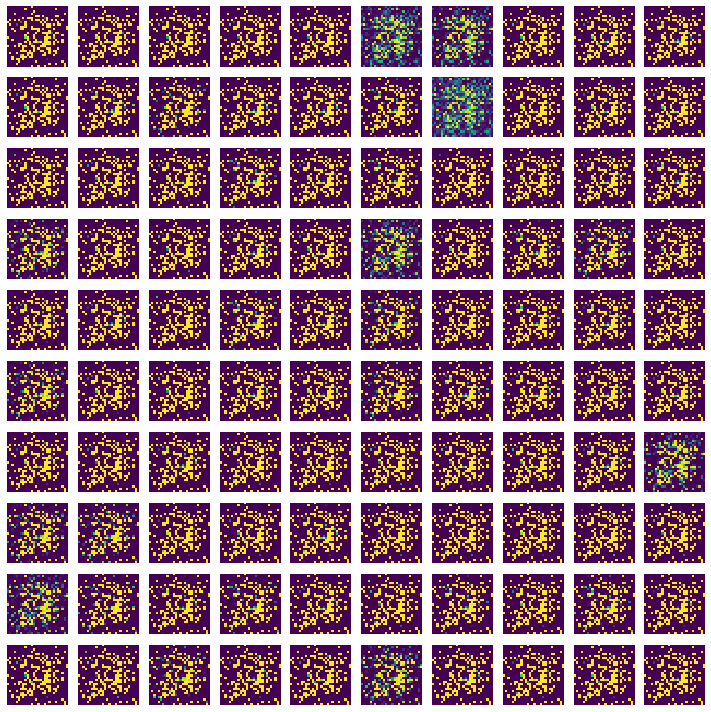

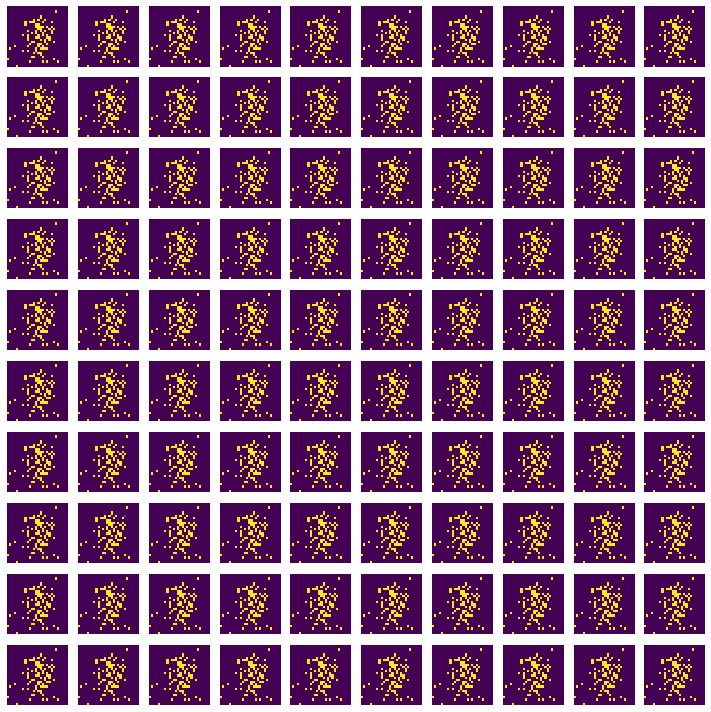

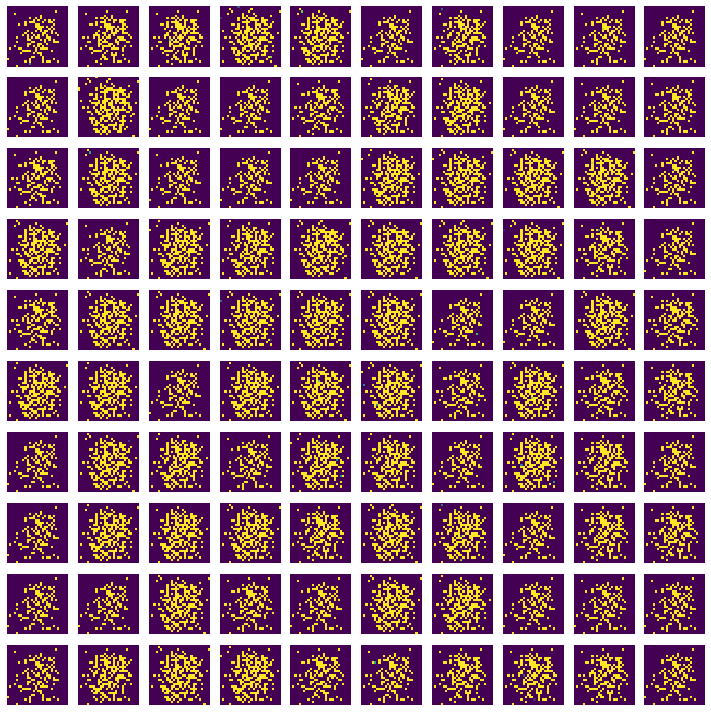

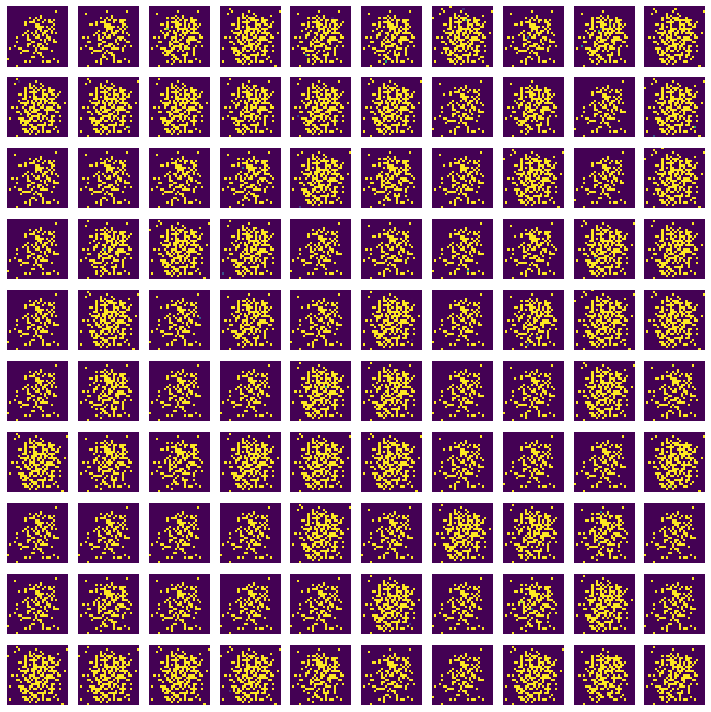

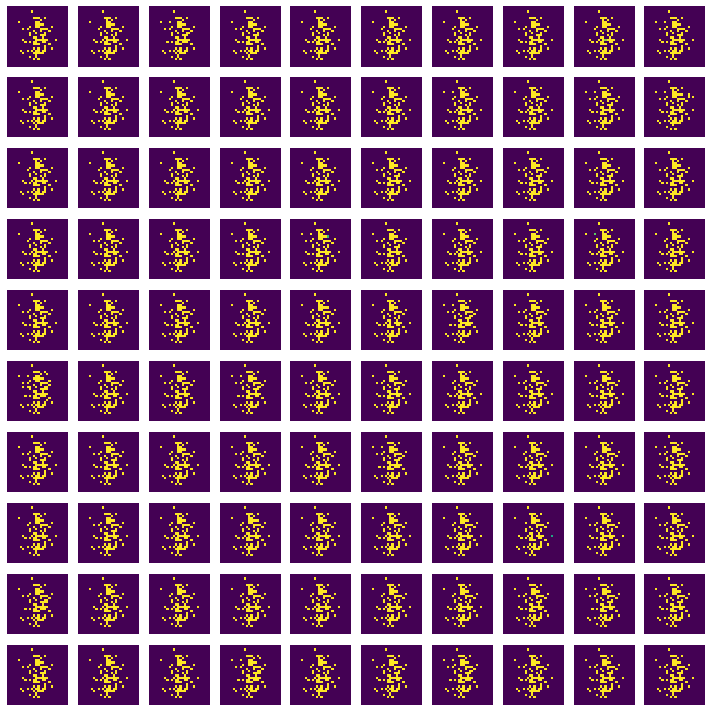

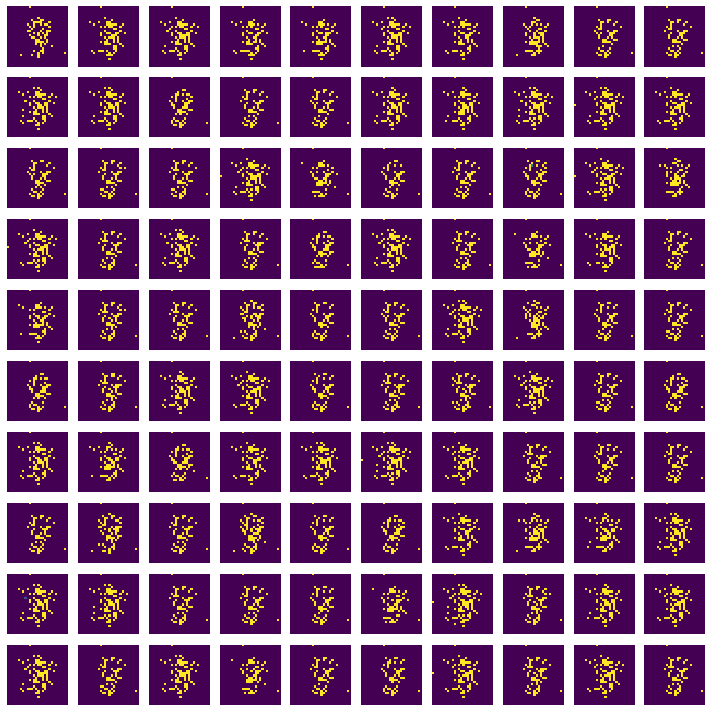

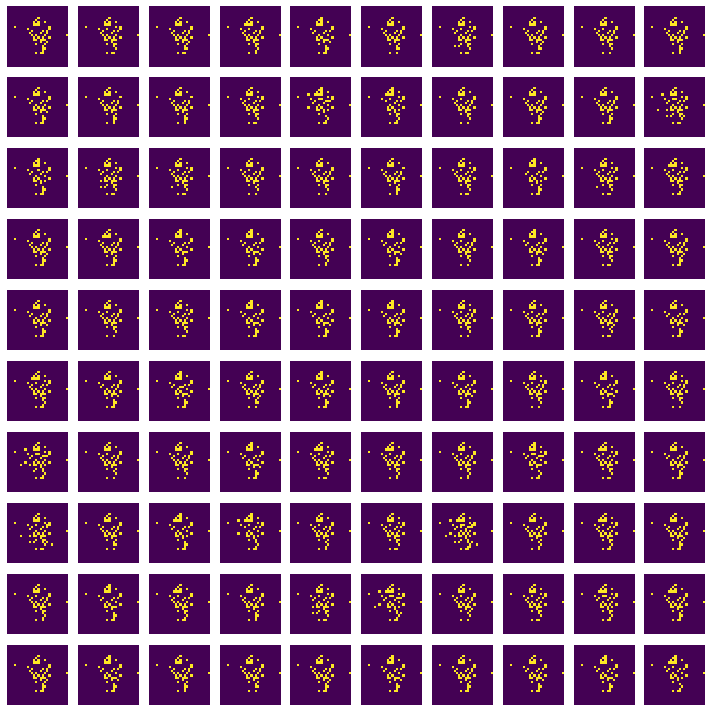

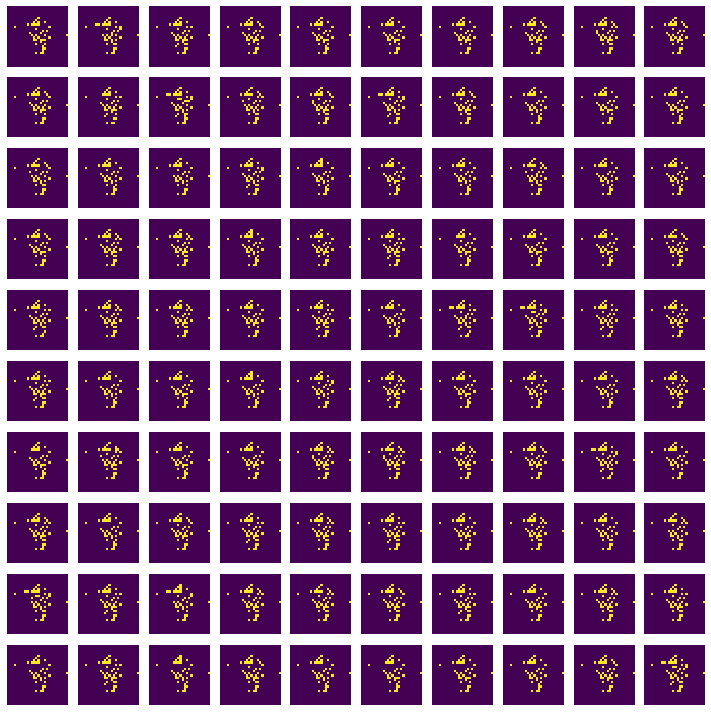

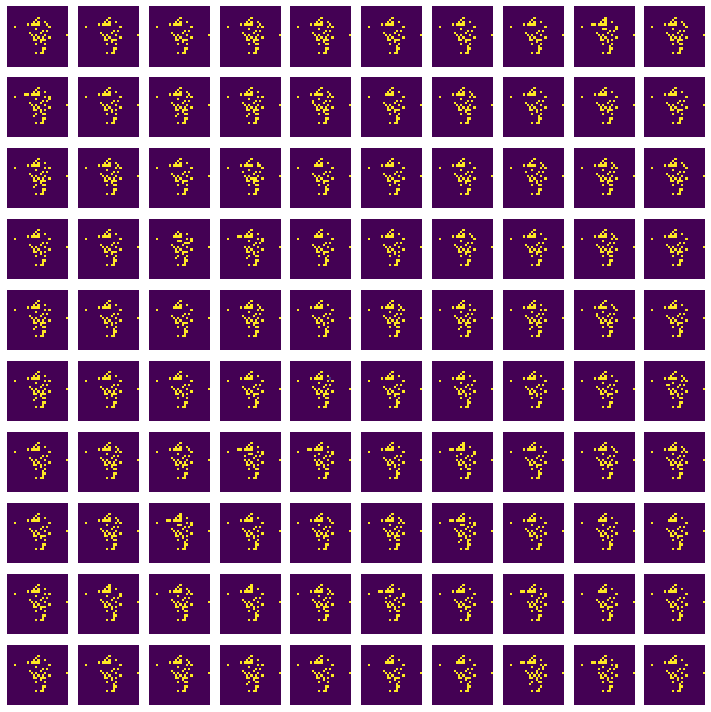

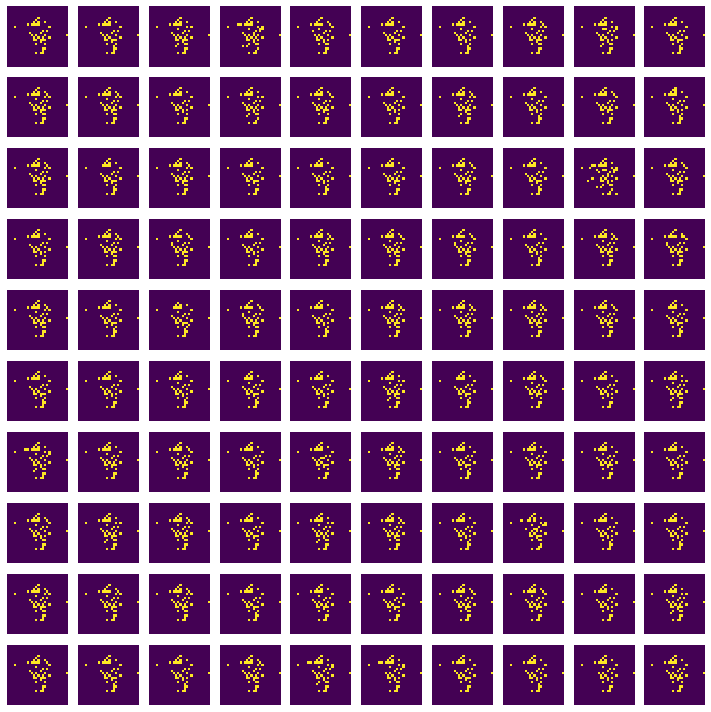

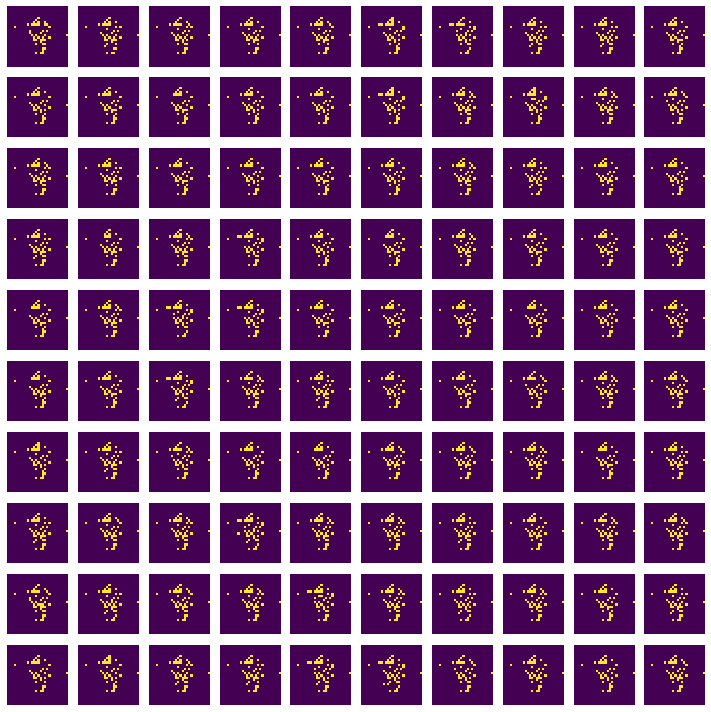

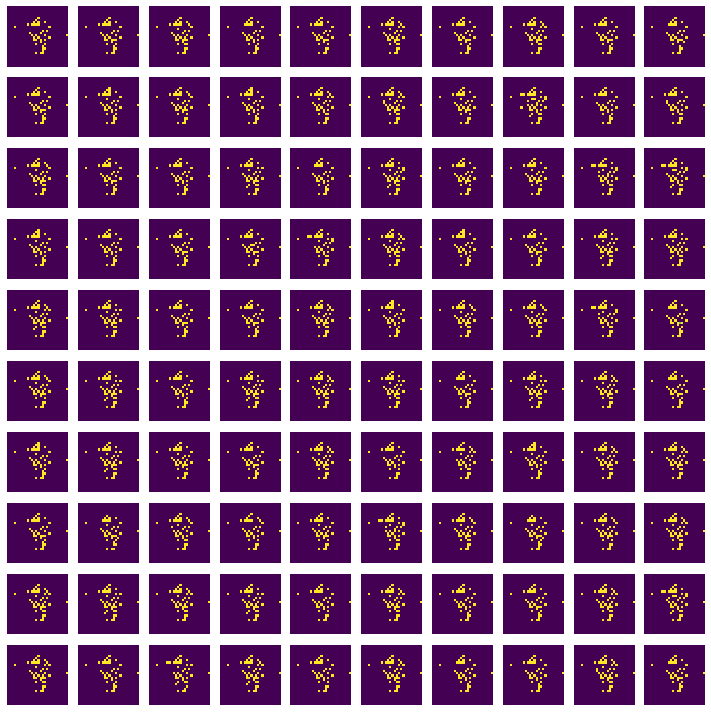

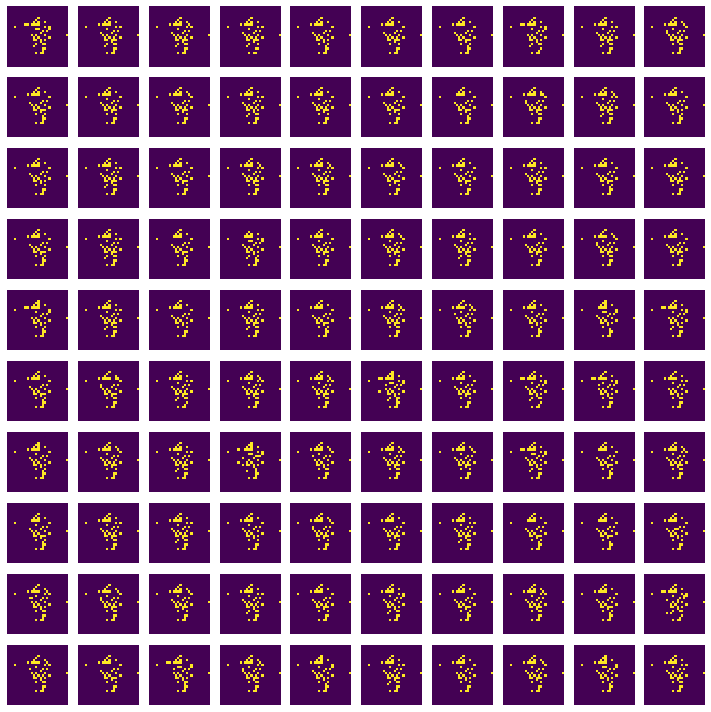

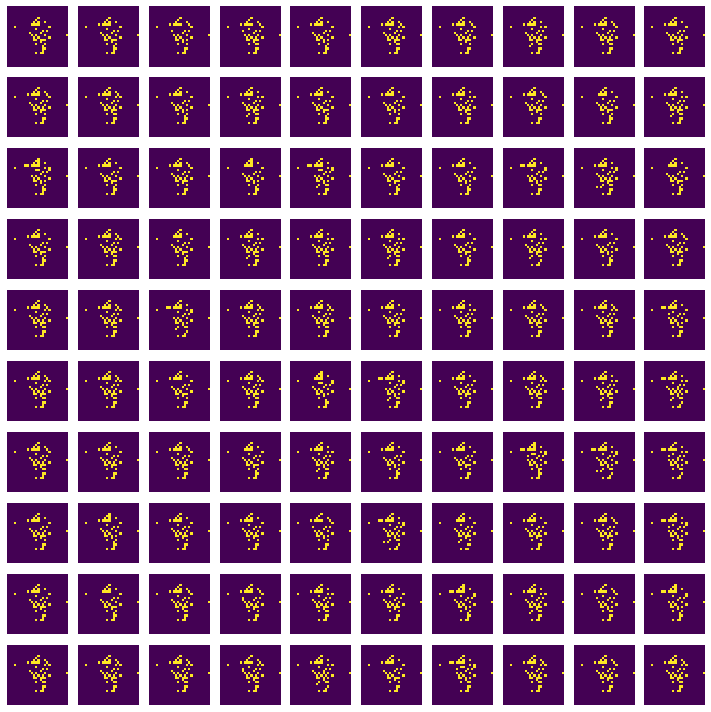

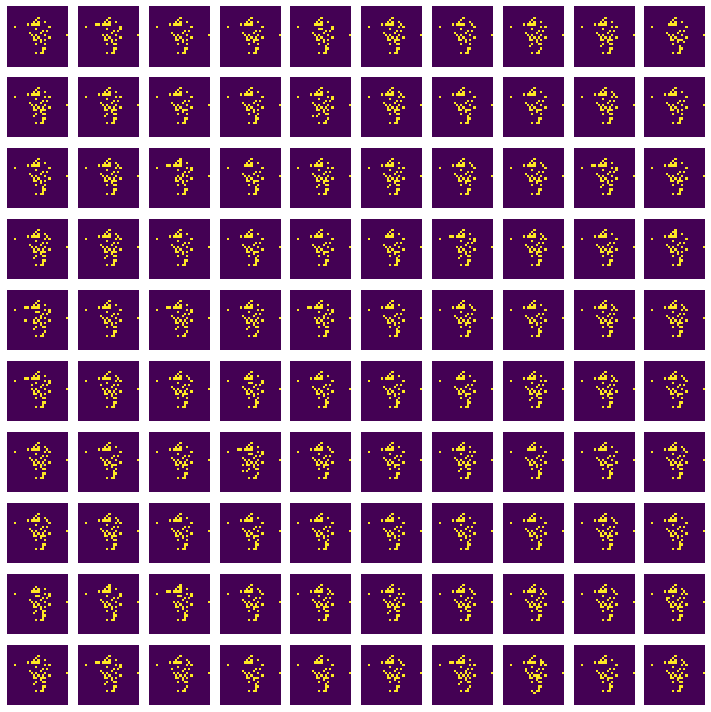

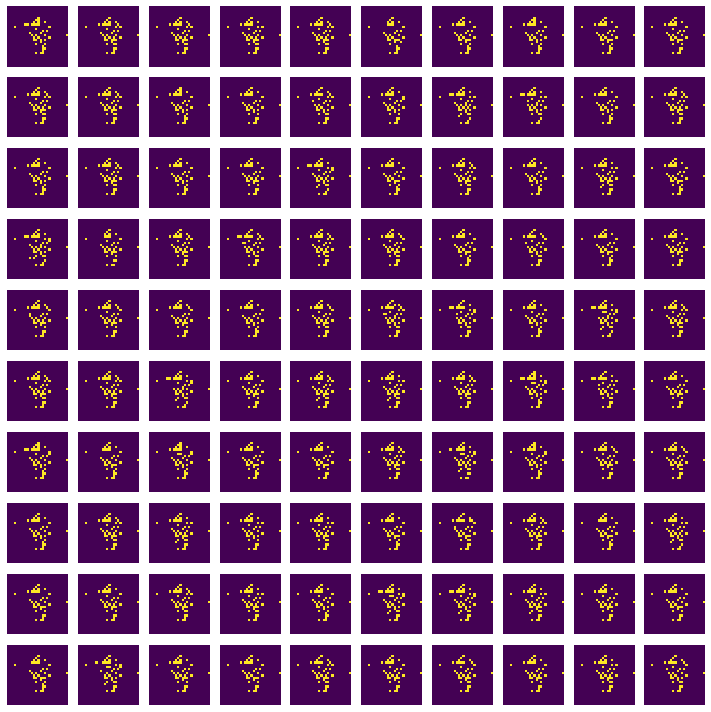

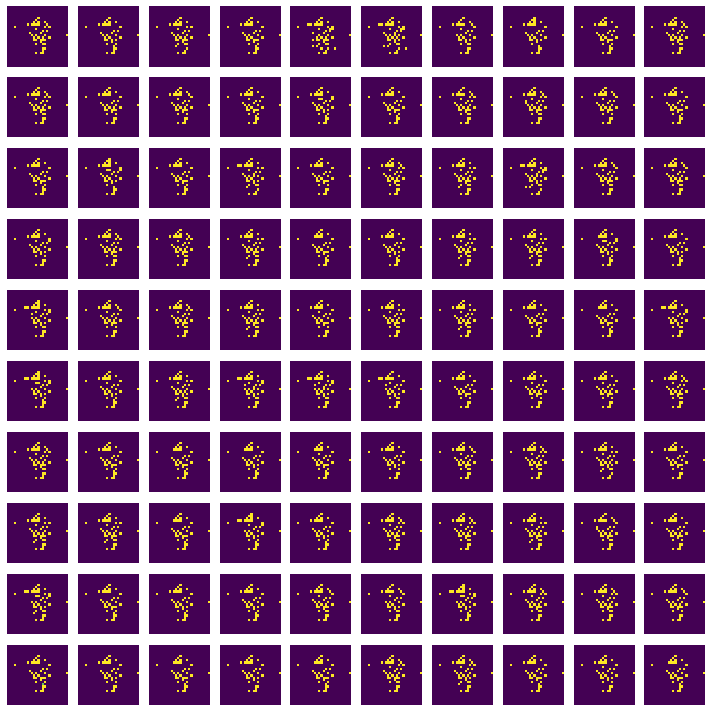

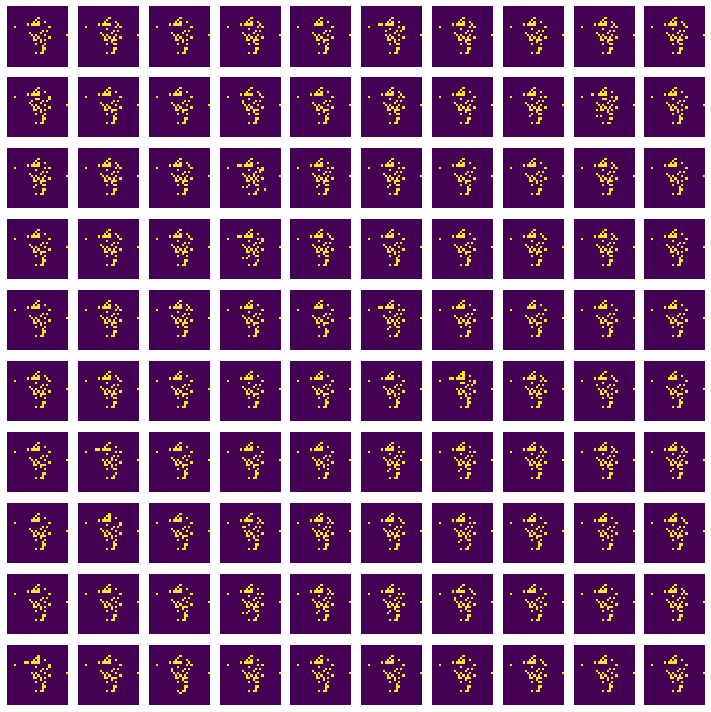

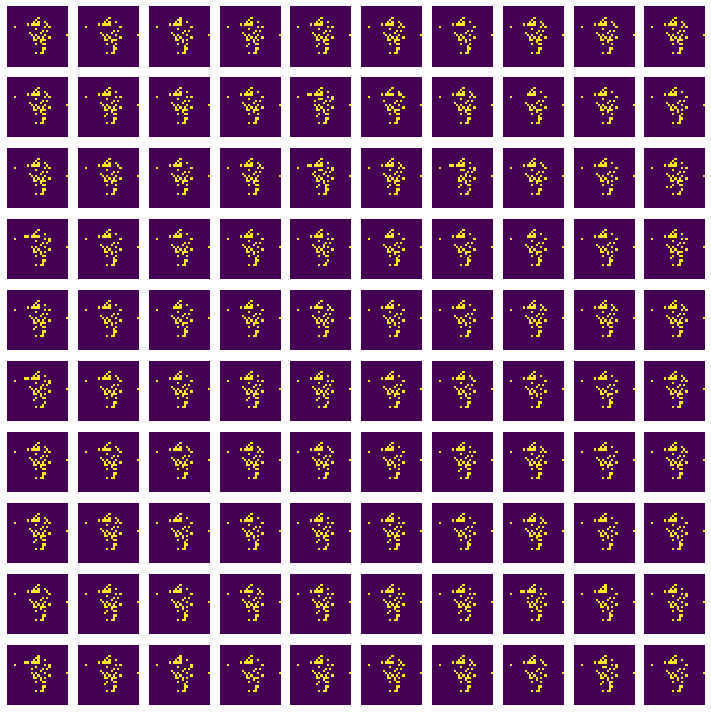

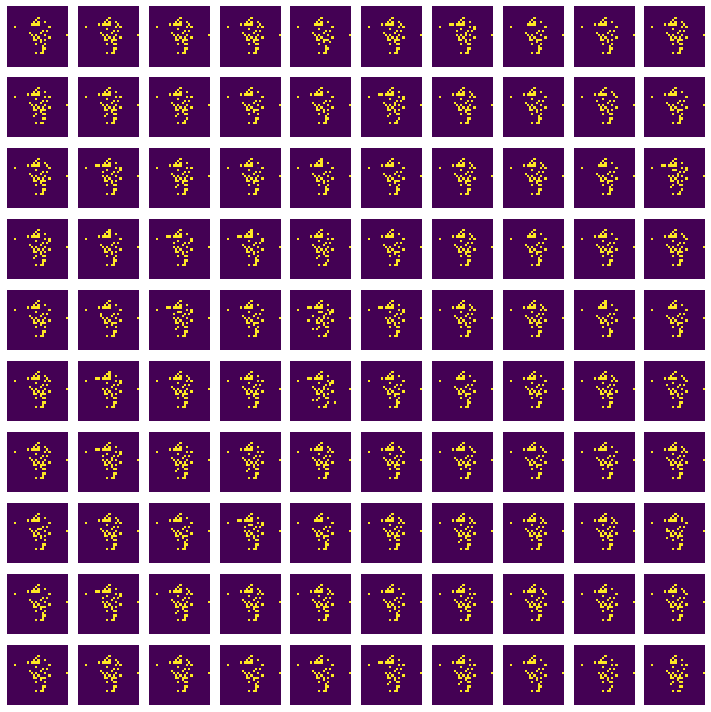

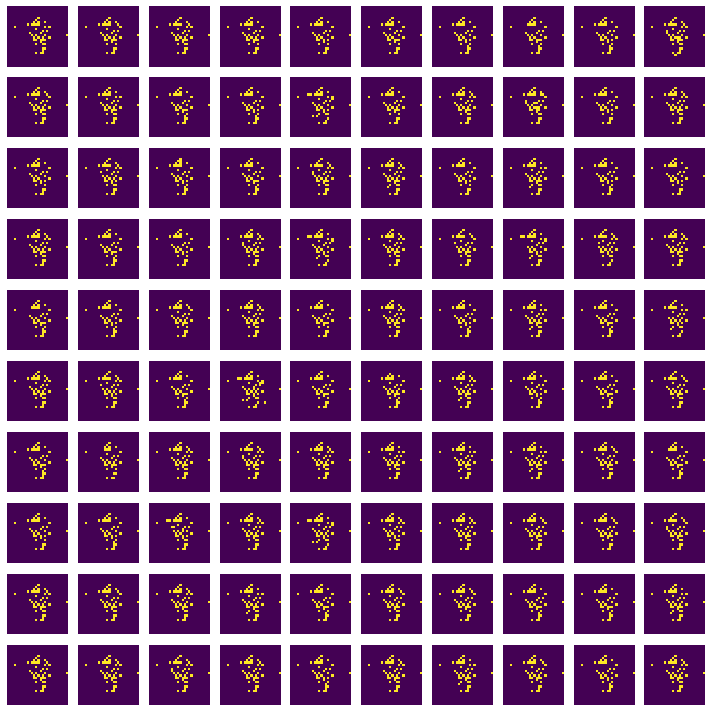

In [9]:
def training(epochs=1, batch_size=128):
    
    #Laden Sie die Daten aus dem mnist-Datensatz
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Erstellen des GANs mit Generator und Diskriminator. 
    ## Zuerst wird das neuronale Netzwerk für Generator und Diskriminator erstellt
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    # Für jede Epoche verwenden wir tqdm , damit unsere Loops eine 
    ## intelligente Fortschrittsanzeige darstellen. 
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
            # Wir erzeugen zufälliges Rauschen, um den Generator zu initialisieren.
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Der Generator generiert dann gefälschte MNIST-Ziffern aus dem gestörten Eingang.
            generated_images = generator.predict(noise)
            
            
            # Wir müssen nun einen Datenstapel erstellen, der gefälschte Bilder vom Generator und
            # echte Bilder aus der MNIST-Datenbank erhält
            # um diese dann an den Diskriminator weiterzuleiten
            
            # ein Set aus zufälligen MNIST-Bildern holen
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            # Eine Folge von Arrays erstellen mit `concatenante` aus den Sets realer und fake bilder 
            X= np.concatenate([image_batch, generated_images])
            
            # Zielvariablen für echte und gefälschte Bilder erstellen
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            
            # Wir trainieren den Diskriminator vor dem Starten der GAN mit einigen gefälschten und echten Daten. 
            
            # Auf diese Weise können wir überprüfen, ob unsere kompilierten Modelle 
            ## sowohl mit unseren Realdaten als auch mit den verrauschten Daten einwandfrei funktionieren.
            
            #Pretraining
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking < wir nehmen den noised input des Generators und verkaufen diesen als echtes bild
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            
            # Wenn wir die GAN trainieren, müssen wir die Gewichte des Diskriminators einfrieren. 
            ## Wir tun dies mit der `trainable flag`
            discriminator.trainable=False
            
            
            # Das GAN wird durch abwechselndes Training des Diskriminators 
            ## und anschließendes Training des verketteten GAN-Modells mit eingefrorenen 
            ## Diskriminatorgewichten trainiert            
            gan.train_on_batch(noise, y_gen)
        
        # Für jeweils 20 Epochen zeichnen wir die erzeugten Bilder            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)
training(400,128)

## possible output:
![](https://miro.medium.com/max/2440/1*xm6_ZfvfKSHe2KS49DT8TQ.png)